In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2], permutation_intervals=2)

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 3.73 s
Wall time: 4.52 s


In [5]:
%%time
train, val, test = data.get_splits(['1st_interval', 'skip', 'omit_distances', 'random_subsample'], [5, [1], [0.5, 0.5]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 180 train | 529 val | 2119 test
CPU times: total: 58 s
Wall time: 1min


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[['.._,,,.,..,,._.,', '.,__w,,..,,,,.__', '.,cr._...,,__.,.', False],
 ['_,,.,_..,..,__,_', ',w,.u,_,_,,_,_,.', 'r_,,_,._.,,.,.__', True],
 [',,____..__..,,_.', ',_,.wu.,._.,.,,,', '_.,_..,.._,_.,..', False],
 [',_,____,,.._,,_.', '..,_...,,,__..__', '_d,.r,._.._..,,.', True],
 ['__,_.,__,,.,__..', '...,,._,.,_,,,__', ',,_dr,__.,..,_._', True],
 [',,,...,.,.._....', ',,wu..,,,,,__,_.', '.,_..,r..,_____,', True],
 ['_,.,.,_,.,,,,._.', ',_,._..,____,.,.', ',,_,_.._,,_.__,.', False],
 [',_.,.,,..,,_....', ',.w,.,__,.,___,_', '.,._,.,._,__._.,', False],
 ['._,,.._...,.,,,,', '.._w.,.,,.,,.,..', ',r,__.,.,__,_,_,', True],
 ['.,,.___,,_,,___.', '...w..u_,_..____', '..,,c_,r__,,,_.,', False],
 [',,,_,,..,,,,._,.', ',,_,_._,.._.,_.,', ',..,.,.__,__,,,_', False],
 ['..,,_.,._,_._,__', '.,,.,,..._,_,.,.', 'cr.,_,,_,.._.,,_', False],
 [',,,.,,,._,_.,_.,', '__,__w,,_,__,__.', 'cr..,_,_,,_,.___', False],
 ['._.,._,_.,,.__..', '_w,_,,_,._,,_.__', '.,.._.__..,,,._,', False],
 ['___....,_.,.,_,,', '_.

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 8 | F2-uw 11 | F2-w 7 | F2-noop 9 | 
F3 cr:    F2-wu 10 | F2-uw 4 | F2-w 9 | F2-noop 12 | 
F3 r:    F2-wu 14 | F2-uw 10 | F2-w 15 | F2-noop 13 | 
F3 noop:    F2-wu 16 | F2-uw 11 | F2-w 15 | F2-noop 16 | 

Positive samples count: 79
Total samples count: 180
Positive class ratio: 0.4388888888888889


#### Peek at test data

In [8]:
test_original[:15]

[['._...,,.._.__..,', '__._.,__.,..,___', '_.,,,,____,r.,_.', True],
 ['_._,,,_.._,.._,_', 'w_u_,_.__,_..,__', ',,_.__.__._,....', False],
 ['._,,,._,_.,,,___', '._,_,,__,___,,..', '___._,,,..._,_,.', False],
 [',..__,._,,__.,._', '_w_.____.,,.__,,', '.,.,.r,_.__,,_,,', True],
 ['_,,,,,.__._,_.__', ',_....,._,_.w.__', '...,__.,,__,r,_.', True],
 ['_._.,_,_,_.,,__,', '___,,,,,_w_,,.__', ',,,,__,__,__r_._', True],
 ['.__..,,.,.._,...', ',,,._u,w..,.,.,.', ',__.,c,r_..._.._', False],
 ['.,..,,,.,.___...', ',..,,..,,u.w_,,,', '_,,__.,__,.d,r_.', True],
 ['_.,,._,..___,_,,', '____,_.,,,w._._.', ',,__,,_._,.,_..,', False],
 ['_,_._,._.,.__.,.', '._.,._..,,_,w.,,', '.,._,.__.,_,.___', False],
 ['..._...,.,.__.,_', '.,,,__.,_.,_,,__', ',,_,,...r,_,.,,_', True],
 ['..,._...________', '_,,,.w....__,,_,', '._.,.,,_,__.___,', False],
 ['__..__..__.,__..', '.._,.,..__w.u._.', '.,,_,...,,,,..,.', False],
 [',.,_,,_,_,,,_.__', '_.,w,u_,,..,.,_.', ',_d_r,_.___._.__', False],
 ['.__.,,_,.,____,,', '_.,

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 74 | F2-uw 77 | F2-w 92 | F2-noop 93 | 
F3 cr:    F2-wu 75 | F2-uw 77 | F2-w 84 | F2-noop 92 | 
F3 r:    F2-wu 89 | F2-uw 82 | F2-w 262 | F2-noop 267 | 
F3 noop:    F2-wu 83 | F2-uw 89 | F2-w 285 | F2-noop 298 | 

Positive samples count: 962
Total samples count: 2119
Positive class ratio: 0.4539877300613497


#### Peek at val data

In [10]:
val_original[:15]

[['..__,____,._,,,_', '.____.,_w,u,__..', '_.,,._._,_,c_r..', False],
 [',_._..,__,.,_,._', ',,_,.,,u.w..,,_,', '_..__.___.,_.._,', False],
 [',__._,,,_,_._,..', '___w_u,,.,.,._..', 'c_r.,_,___,,,..,', False],
 ['..,,,__,,.,,.._,', '.,,,.,_,..,__.,.', ',,,._._._.__,,,_', False],
 ['._,._,_,_.,,_.__', ',.,..w_.__.,._,_', ',,r__..,,,_.._,_', True],
 ['_,,.,__._,.._.,.', ',,_._.,__,,,,___', '__._.._,___r_,_.', True],
 ['..._,_..,,._.___', ',..,,w.u,,,_____', ',_,__,._,.__.,_.', False],
 ['_._,___._,,,__._', ',,__,,,.,_,.._.,', '.,.,._,,.__r.._.', True],
 ['_.,.,._.___,,._,', '__,..._._.__,,.,', '____,,,._,__,,_,', False],
 ['_.,.,_..,__.___,', ',__,.__,____.___', ',,,.,.,,,._,.,._', False],
 ['__,_._._,_,__..,', '_,.______.,.u,w_', '..,,...___,__,,,', False],
 [',,_,.__,..,.,,..', '_..,..,,_..,w_u_', '_.,_._,.,r.._.,,', True],
 ['..___.__,__.,_..', 'u.w_,.,__,,,_.,,', '.,.,.,..____,_,_', False],
 [',.____,,____.,,,', '._,,___,,,._,_,,', '.,__,_r,._._..__', True],
 ['_,,__._,.,_,_,._', ',.

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 24 | F2-uw 21 | F2-w 13 | F2-noop 19 | 
F3 cr:    F2-wu 23 | F2-uw 21 | F2-w 21 | F2-noop 20 | 
F3 r:    F2-wu 16 | F2-uw 23 | F2-w 62 | F2-noop 81 | 
F3 noop:    F2-wu 29 | F2-uw 23 | F2-w 61 | F2-noop 72 | 

Positive samples count: 235
Total samples count: 529
Positive class ratio: 0.444234404536862


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([180, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([180, 160])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train, padding_left_size=2, padding_right_size=0)
x_val_lstm = data.to_lstm_format(x_val, padding_left_size=0, padding_right_size=2)
x_test_lstm = data.to_lstm_format(x_test, padding_left_size=0, padding_right_size=2)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([180, 18, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "all_filters"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break

        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model best validation accuracy:", best_accuracy)

    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')


1 / 20 models trained | Current model best validation accuracy: 0.9636621047663992
2 / 20 models trained | Current model best validation accuracy: 0.9636621047663992
3 / 20 models trained | Current model best validation accuracy: 0.9636621047663992
4 / 20 models trained | Current model best validation accuracy: 0.9650778669183577
5 / 20 models trained | Current model best validation accuracy: 0.9650778669183577
6 / 20 models trained | Current model best validation accuracy: 0.9650778669183577
7 / 20 models trained | Current model best validation accuracy: 0.9650778669183577
8 / 20 models trained | Current model best validation accuracy: 0.9650778669183577
9 / 20 models trained | Current model best validation accuracy: 0.9650778669183577
10 / 20 models trained | Current model best validation accuracy: 0.9650778669183577
11 / 20 models trained | Current model best validation accuracy: 0.9660217083529967
12 / 20 models trained | Current model best validation accuracy: 0.9664936290703162
1

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.8924020764511562
2 / 20 models trained | Current model best validation accuracy: 0.8924020764511562
3 / 20 models trained | Current model best validation accuracy: 0.8924020764511562
4 / 20 models trained | Current model best validation accuracy: 0.9344030202925908
5 / 20 models trained | Current model best validation accuracy: 0.9344030202925908
6 / 20 models trained | Current model best validation accuracy: 0.9344030202925908
7 / 20 models trained | Current model best validation accuracy: 0.9391222274657858
8 / 20 models trained | Current model best validation accuracy: 0.9391222274657858
9 / 20 models trained | Current model best validation accuracy: 0.9391222274657858
10 / 20 models trained | Current model best validation accuracy: 0.9391222274657858
11 / 20 models trained | Current model best validation accuracy: 0.9391222274657858
12 / 20 models trained | Current model best validation accuracy: 0.9391222274657858
1

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores,deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.610193487494101
2 / 20 models trained | Current model best validation accuracy: 0.610193487494101
3 / 20 models trained | Current model best validation accuracy: 0.610193487494101
4 / 20 models trained | Current model best validation accuracy: 0.6125530910806984
5 / 20 models trained | Current model best validation accuracy: 0.6177442189712128
6 / 20 models trained | Current model best validation accuracy: 0.6177442189712128
7 / 20 models trained | Current model best validation accuracy: 0.6177442189712128
8 / 20 models trained | Current model best validation accuracy: 0.6257668711656442
9 / 20 models trained | Current model best validation accuracy: 0.6257668711656442
10 / 20 models trained | Current model best validation accuracy: 0.6304860783388391
11 / 20 models trained | Current model best validation accuracy: 0.6304860783388391
12 / 20 models trained | Current model best validation accuracy: 0.6304860783388391
13 /

In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
2 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
3 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
4 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
5 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
6 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
7 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
8 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
9 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
10 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
11 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
12 / 20 models trained | Current model best validation accuracy: 0.4539877300613497
1

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.609249646059462
2 / 20 models trained | Current model best validation accuracy: 0.6130250117980179
3 / 20 models trained | Current model best validation accuracy: 0.6130250117980179
4 / 20 models trained | Current model best validation accuracy: 0.6130250117980179
5 / 20 models trained | Current model best validation accuracy: 0.6309579990561586
6 / 20 models trained | Current model best validation accuracy: 0.6309579990561586
7 / 20 models trained | Current model best validation accuracy: 0.6309579990561586
8 / 20 models trained | Current model best validation accuracy: 0.6309579990561586
9 / 20 models trained | Current model best validation accuracy: 0.6356772062293534
10 / 20 models trained | Current model best validation accuracy: 0.6356772062293534
11 / 20 models trained | Current model best validation accuracy: 0.6422840962718264
12 / 20 models trained | Current model best validation accuracy: 0.6422840962718264
13

# Evaluation

In [26]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [27]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score
0                     CNN  0.966494   0.935484  0.994802  0.964232
1                    LSTM  0.944785   0.928065  0.952183  0.939969
2  DeepSet(like in paper)  0.630486   0.642289  0.419958  0.507857
3   DeepSet(sum at start)  0.453988   0.453988  1.000000  0.624473
4             Feedforward  0.642284   0.706478  0.362786  0.479396


## Accuracies per CNN model

In [28]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,96.4%,99.1%,78.0%,100.0%,100.0%
CNN #1,96.1%,98.5%,78.0%,100.0%,99.6%
CNN #2,96.1%,100.0%,75.9%,100.0%,99.9%
CNN #3,96.5%,100.0%,78.0%,100.0%,100.0%
CNN #4,96.3%,100.0%,76.8%,100.0%,100.0%
CNN #5,95.7%,96.6%,76.2%,100.0%,100.0%
CNN #6,94.4%,90.5%,78.0%,100.0%,98.1%
CNN #7,82.4%,11.3%,78.0%,100.0%,98.7%
CNN #8,96.4%,99.1%,78.0%,100.0%,100.0%
CNN #9,96.3%,100.0%,78.0%,100.0%,99.4%


## Accuracies per LSTM model

In [29]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,89.2%,100.0%,75.6%,99.6%,79.6%
LSTM #1,88.8%,100.0%,72.3%,99.7%,79.6%
LSTM #2,84.5%,100.0%,72.3%,81.6%,86.1%
LSTM #3,93.4%,100.0%,78.3%,98.7%,92.0%
LSTM #4,93.1%,100.0%,78.0%,98.4%,91.4%
LSTM #5,89.8%,100.0%,74.1%,95.6%,86.1%
LSTM #6,93.9%,99.7%,77.1%,98.9%,93.9%
LSTM #7,93.3%,100.0%,77.7%,100.0%,90.4%
LSTM #8,86.8%,97.6%,72.0%,88.3%,87.1%
LSTM #9,91.5%,100.0%,77.4%,93.2%,92.3%


## Accuracies per DeepSets V1 model

In [30]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,61.0%,75.0%,46.1%,76.6%,44.9%
DeepSet(like in paper) #1,57.5%,69.5%,46.4%,70.1%,43.7%
DeepSet(like in paper) #2,58.7%,82.3%,40.2%,74.0%,39.9%
DeepSet(like in paper) #3,61.3%,82.0%,45.2%,80.4%,38.6%
DeepSet(like in paper) #4,61.8%,84.5%,41.4%,80.1%,41.1%
DeepSet(like in paper) #5,59.7%,74.7%,42.6%,78.8%,40.3%
DeepSet(like in paper) #6,60.0%,88.4%,39.9%,84.5%,29.9%
DeepSet(like in paper) #7,62.6%,83.5%,42.9%,85.7%,37.3%
DeepSet(like in paper) #8,62.1%,85.7%,40.2%,84.2%,37.6%
DeepSet(like in paper) #9,63.0%,80.5%,42.9%,83.2%,42.9%


## Accuracies per DeepSets V2 model

In [31]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #1,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #2,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #3,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #4,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #5,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #6,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #7,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #8,45.4%,0.0%,78.0%,0.0%,100.0%
DeepSet(sum at start) #9,45.4%,0.0%,78.0%,0.0%,100.0%


## Accuracies per FeedForward model

In [32]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,60.9%,81.1%,41.1%,82.4%,37.9%
Feedforward #1,61.3%,85.4%,44.0%,77.4%,41.0%
Feedforward #2,61.1%,85.4%,43.5%,83.6%,33.9%
Feedforward #3,57.6%,76.2%,44.3%,76.7%,34.6%
Feedforward #4,63.1%,83.8%,43.2%,84.5%,39.9%
Feedforward #5,60.5%,74.4%,48.5%,75.4%,43.9%
Feedforward #6,61.4%,80.8%,41.1%,83.8%,38.0%
Feedforward #7,56.8%,75.0%,42.3%,69.8%,41.1%
Feedforward #8,63.6%,84.1%,44.6%,82.4%,42.7%
Feedforward #9,63.4%,85.1%,41.1%,85.6%,40.0%


# Training evolution

### CNN

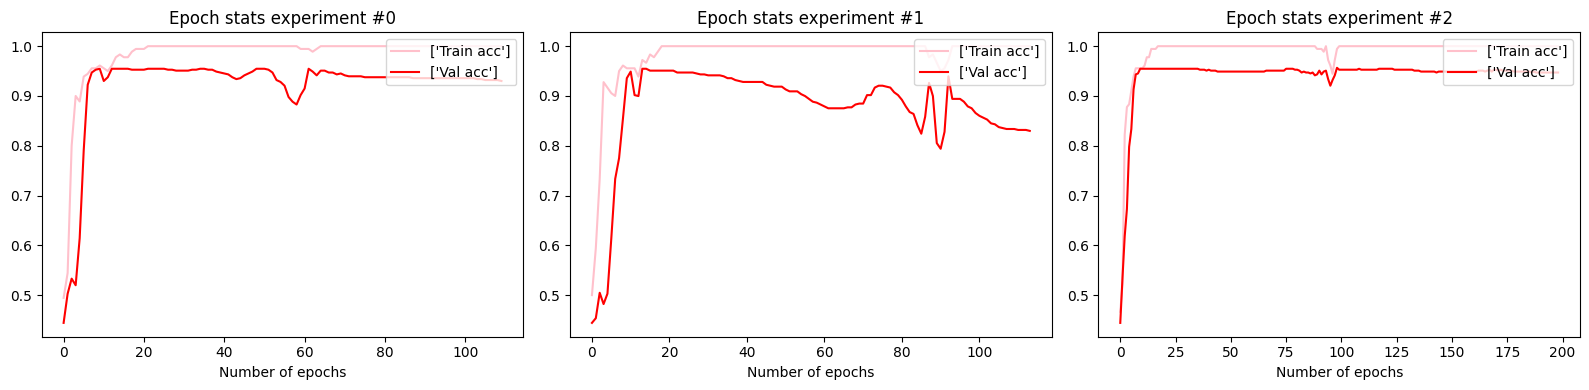

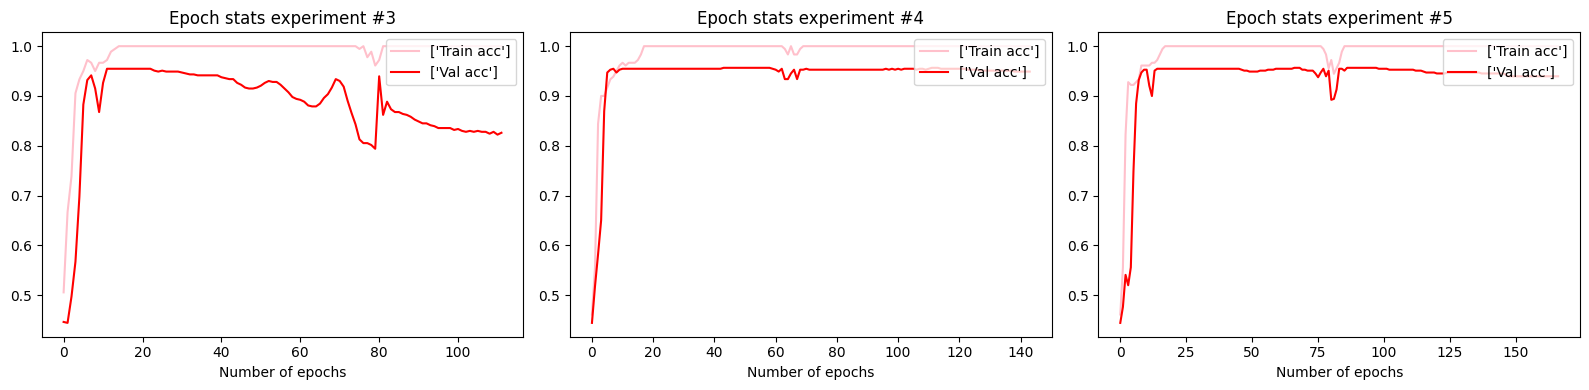

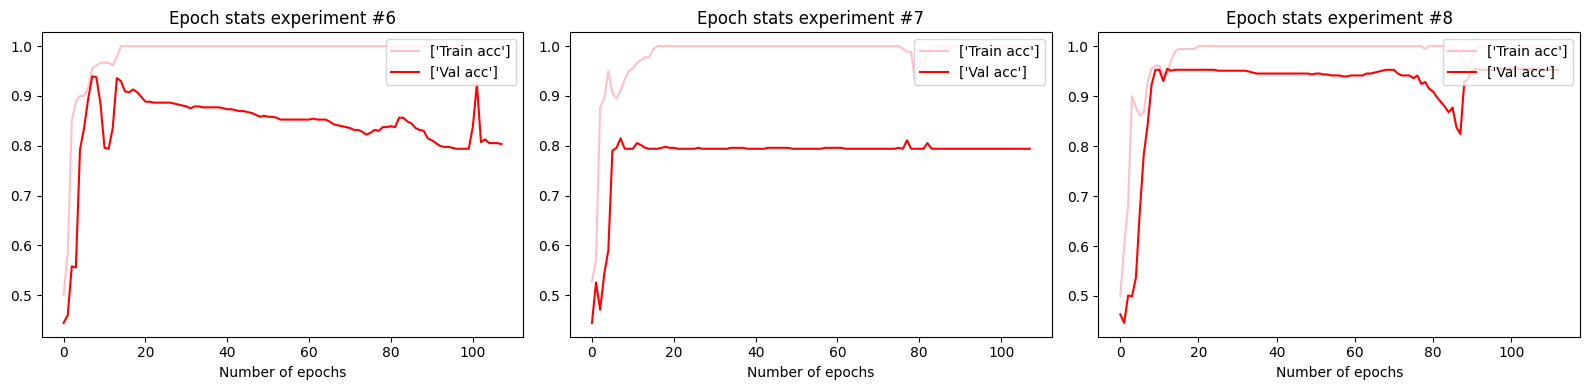

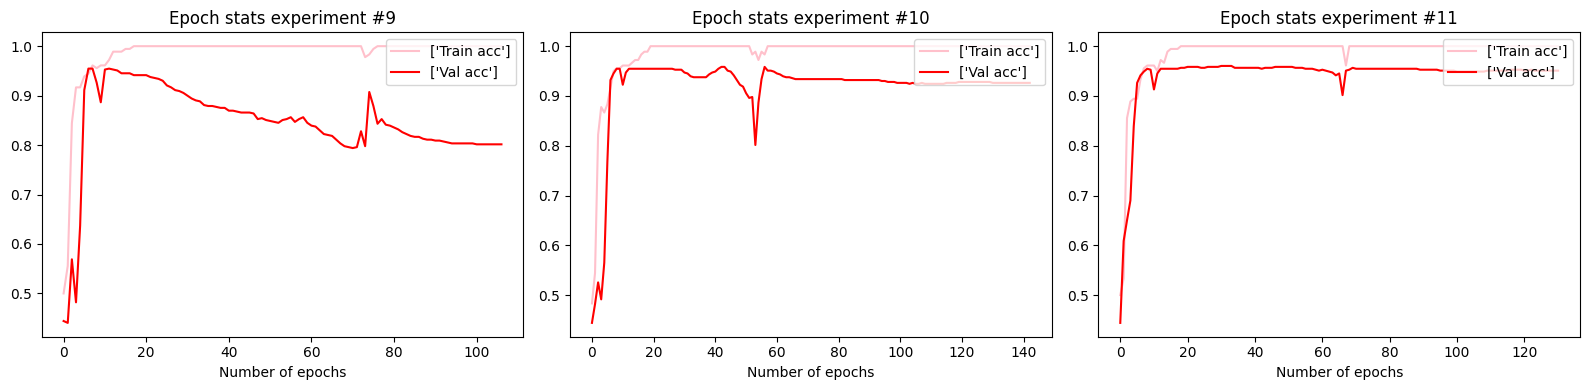

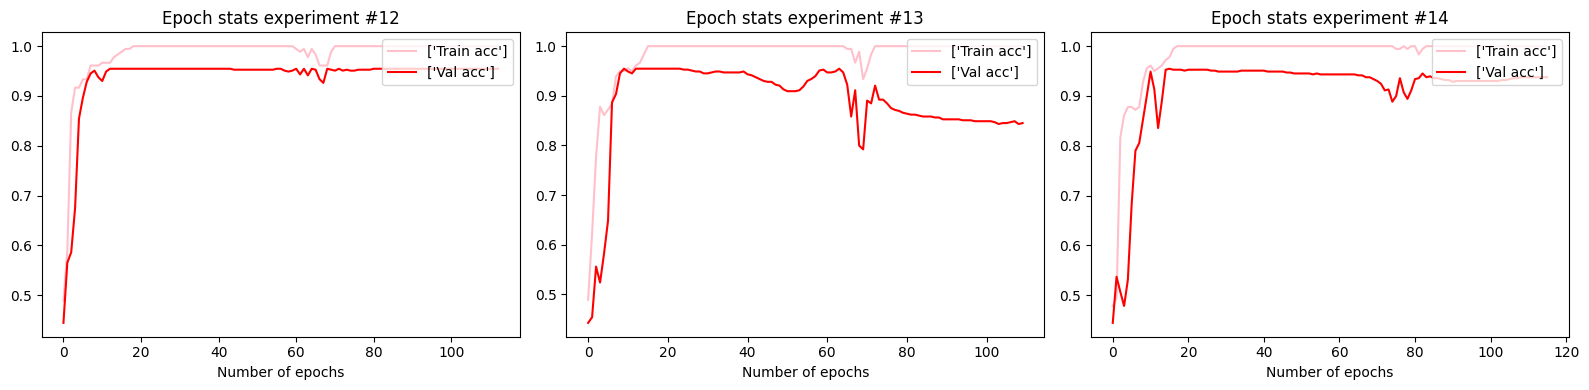

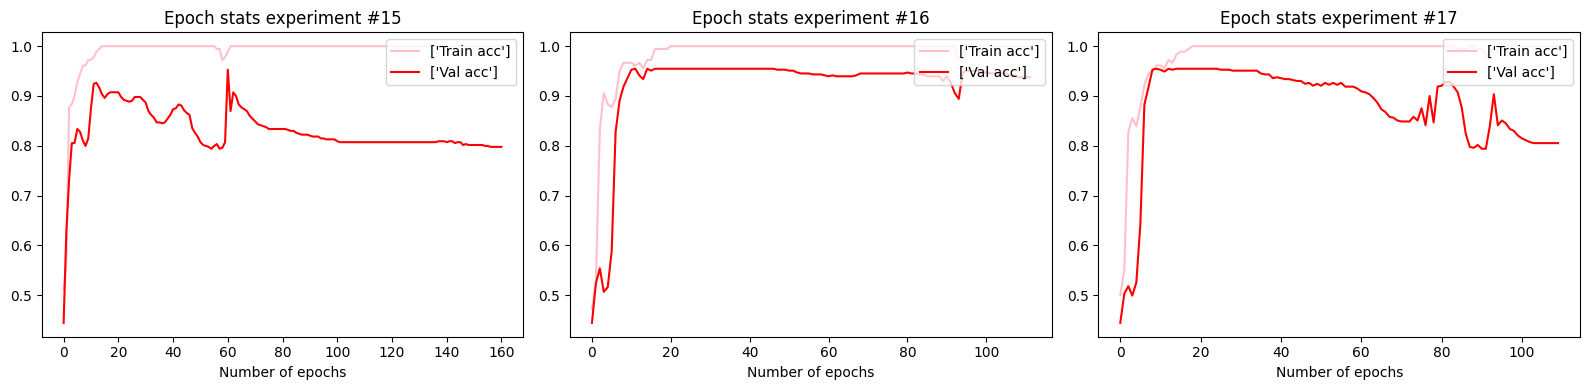

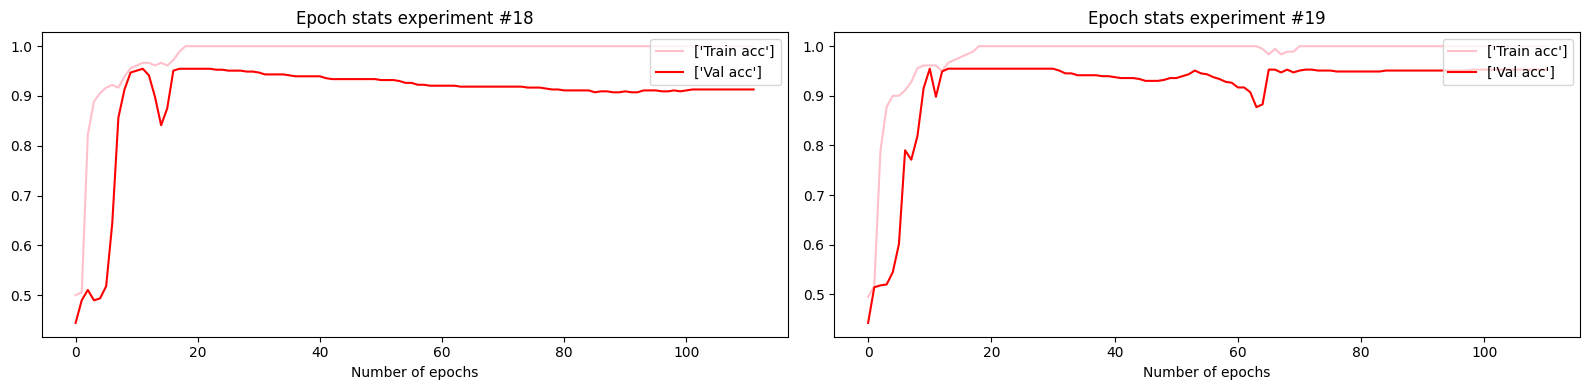

In [33]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

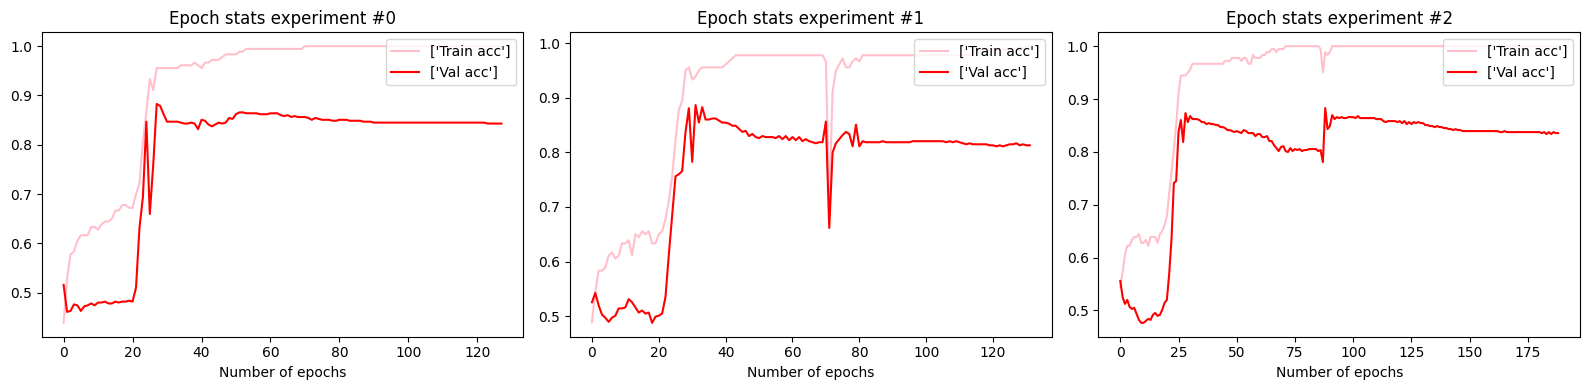

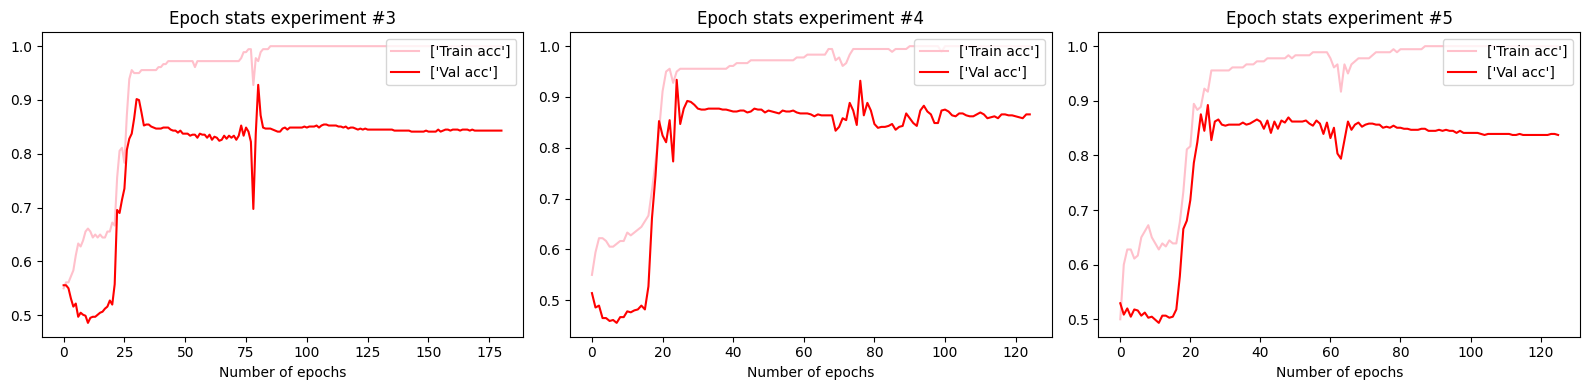

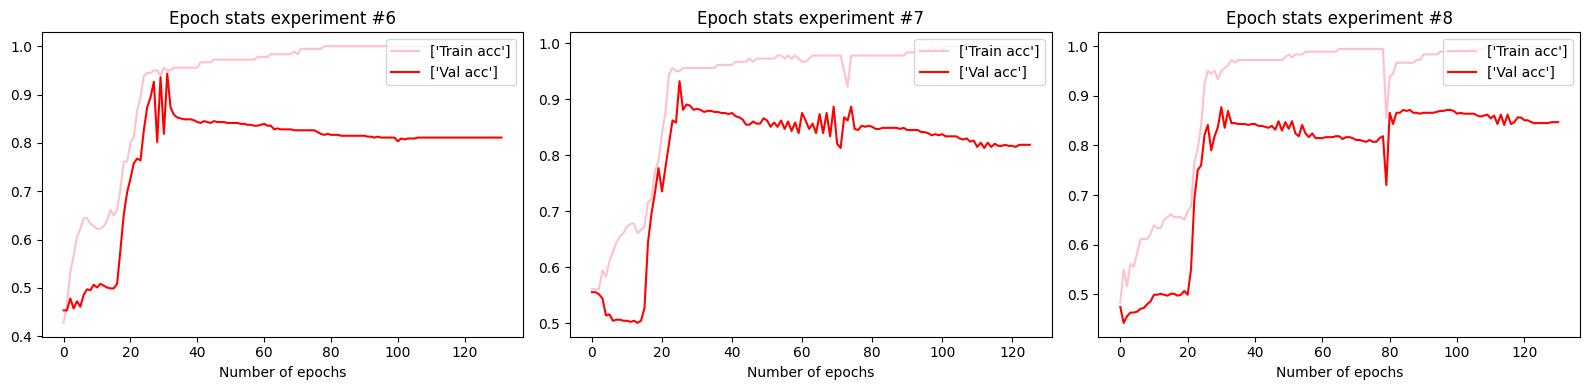

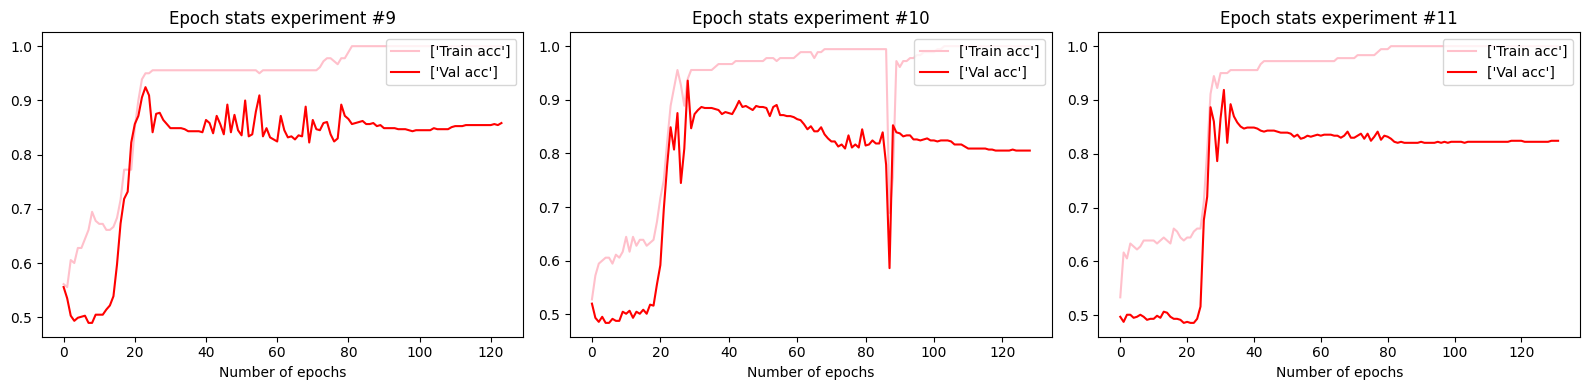

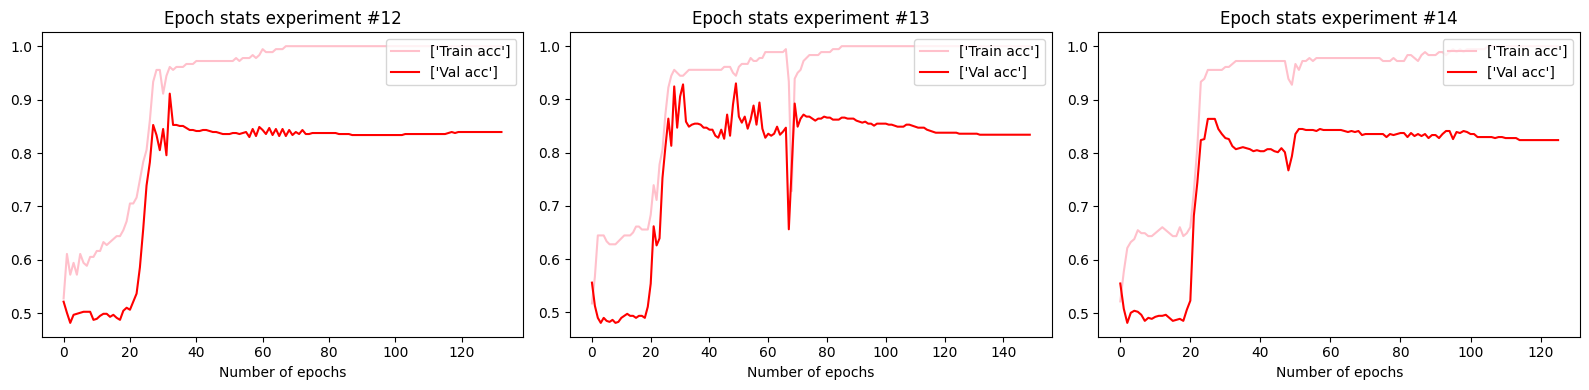

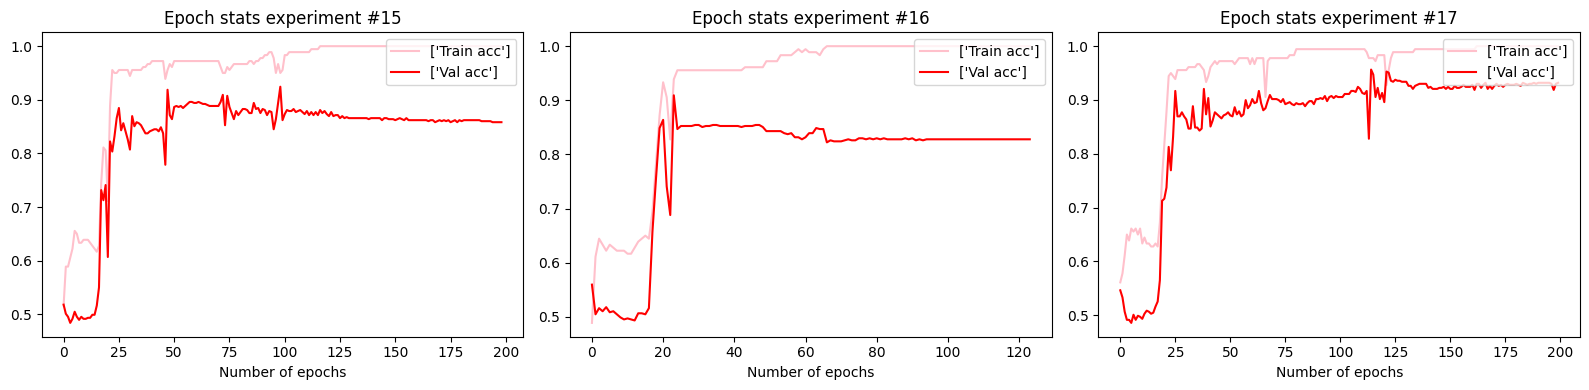

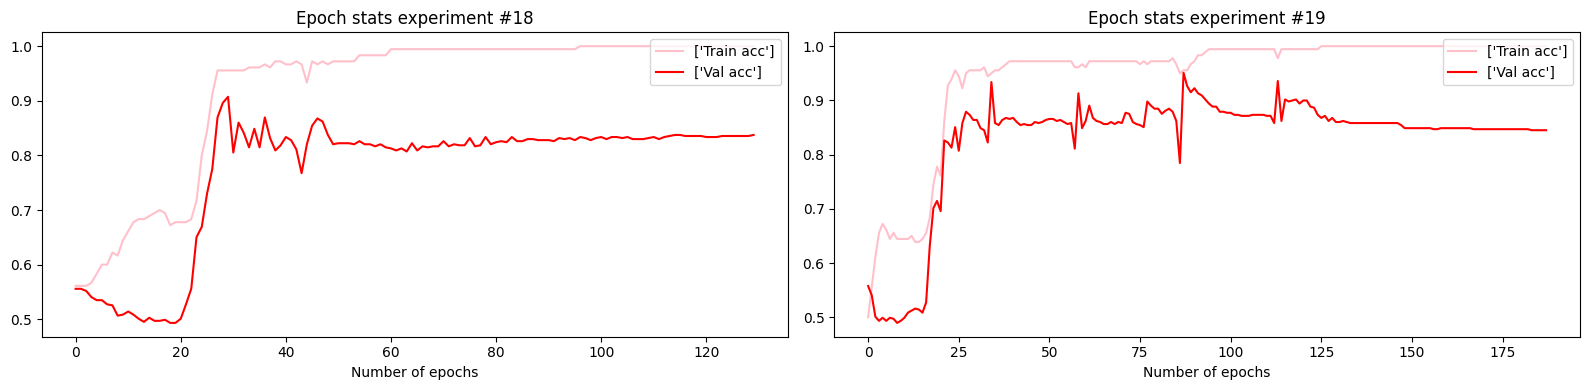

In [34]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

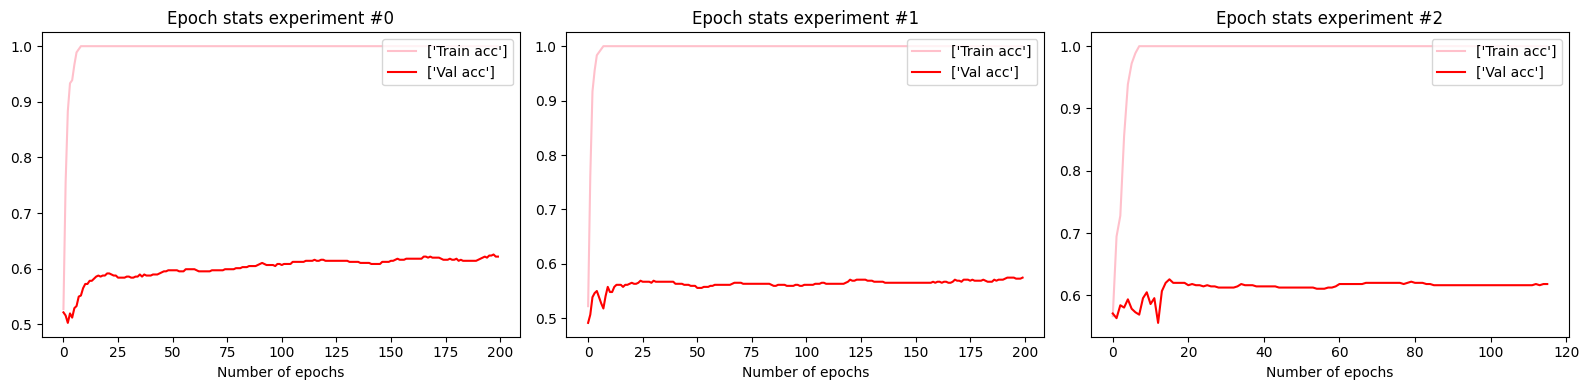

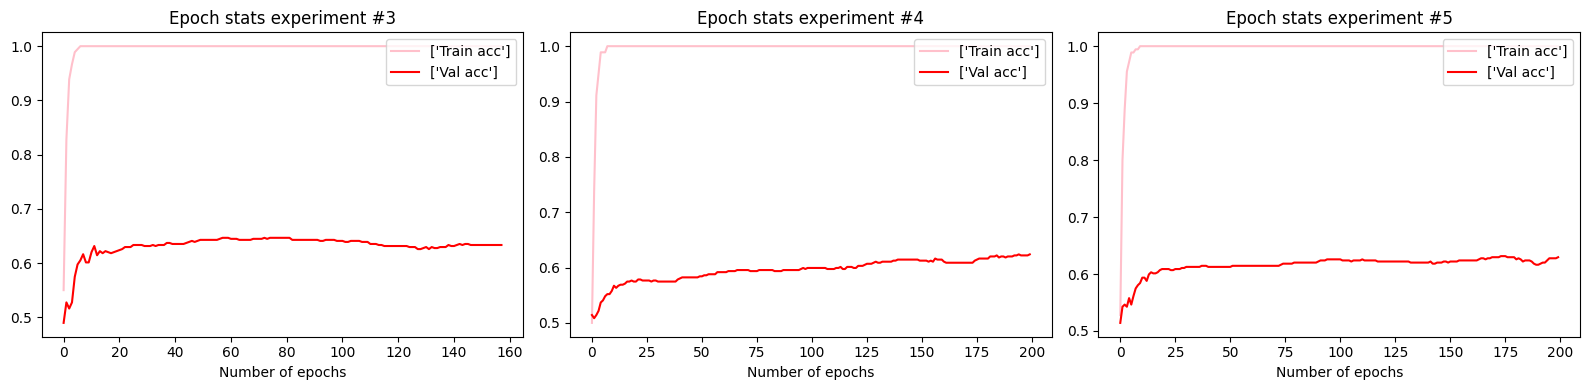

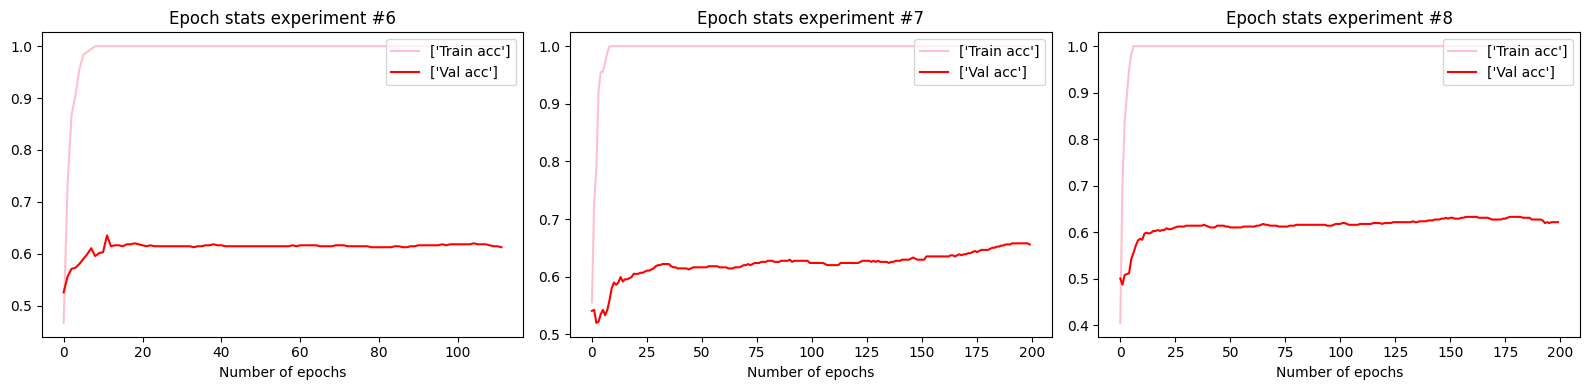

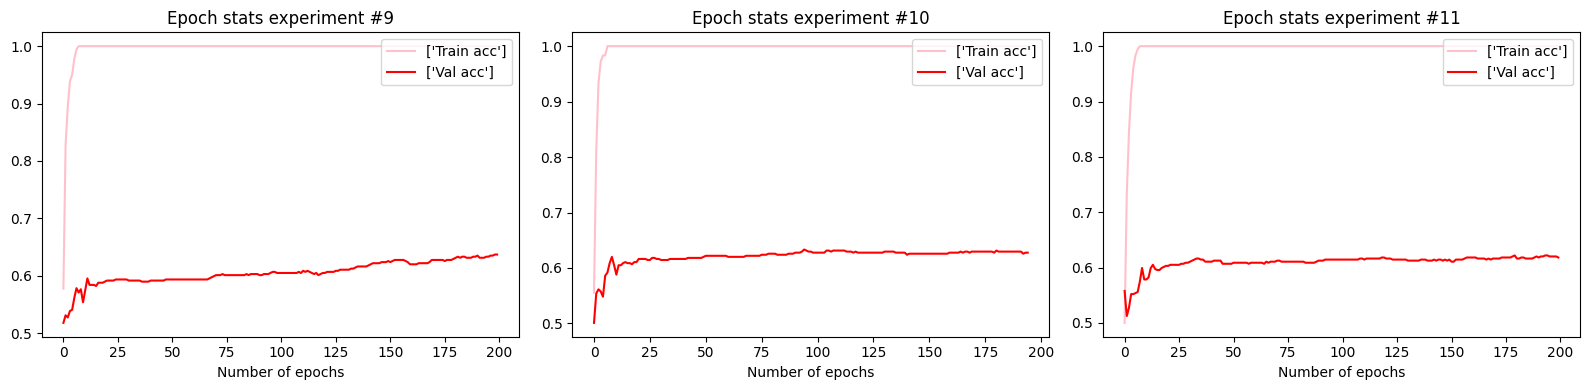

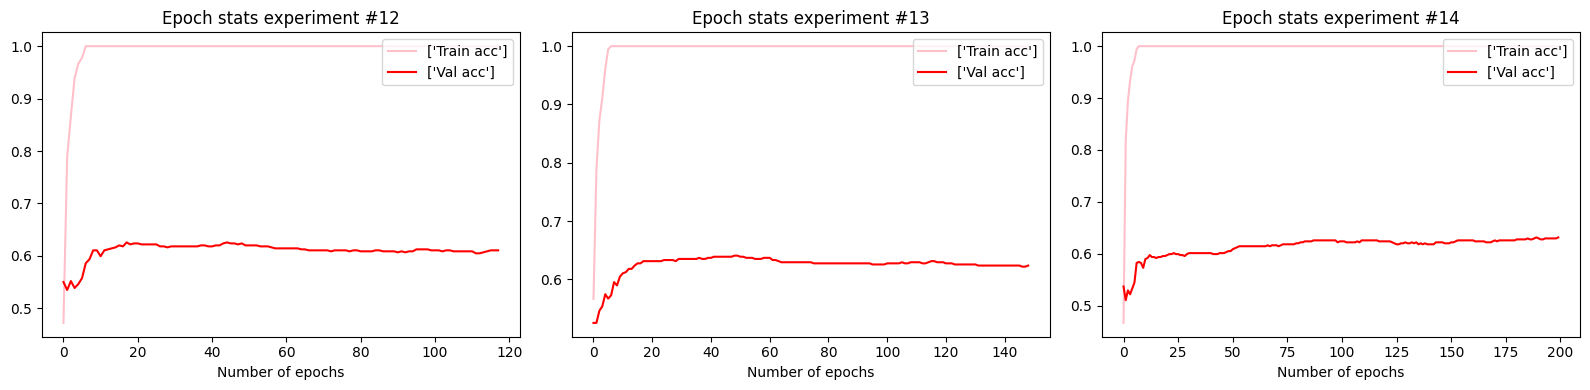

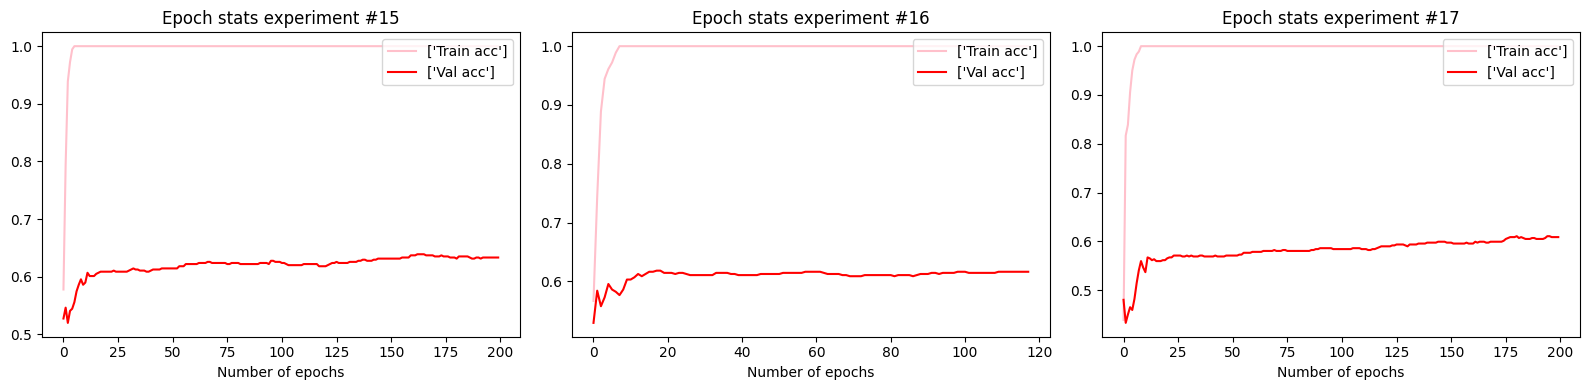

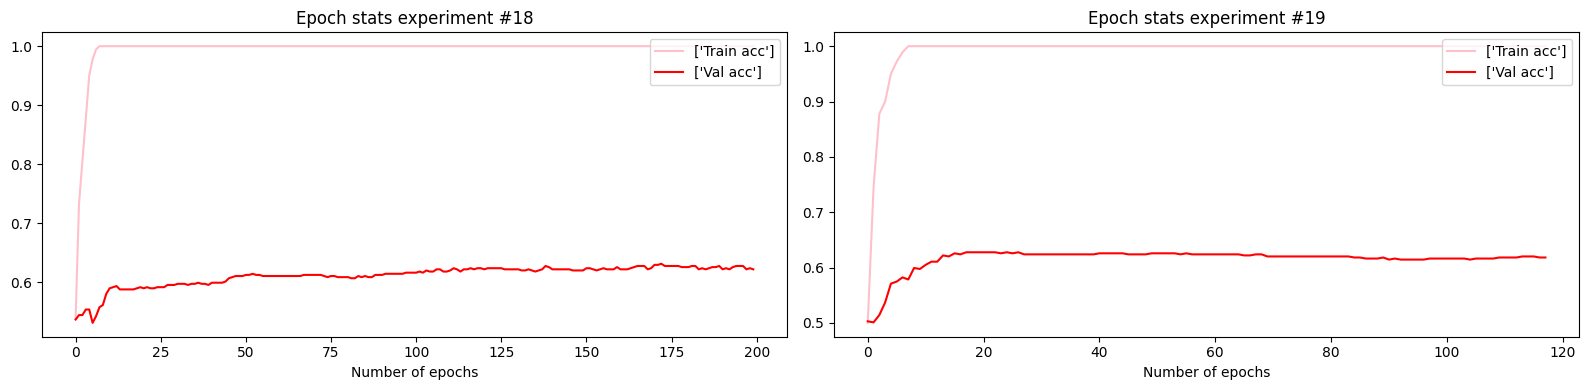

In [35]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

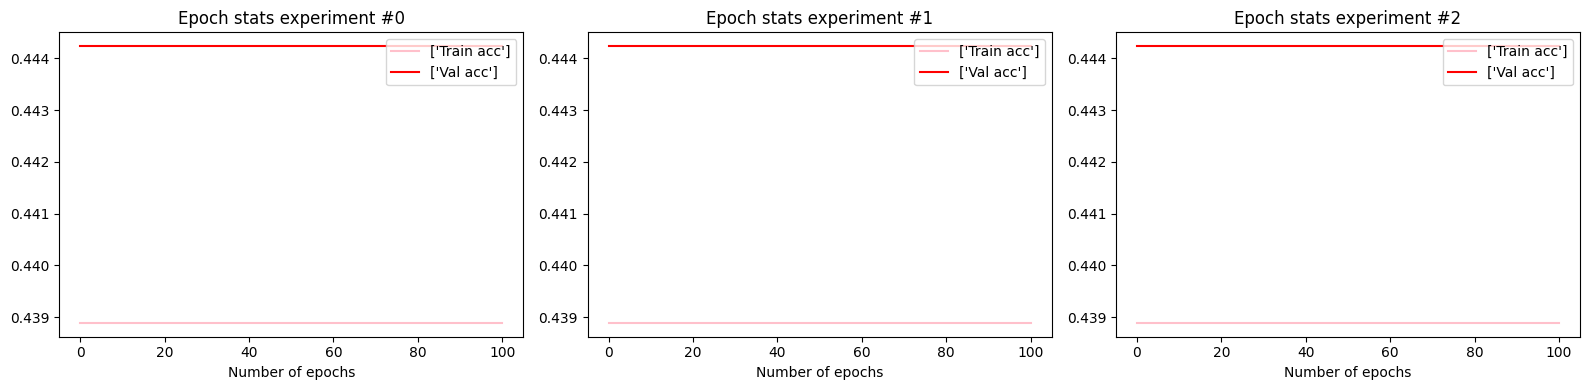

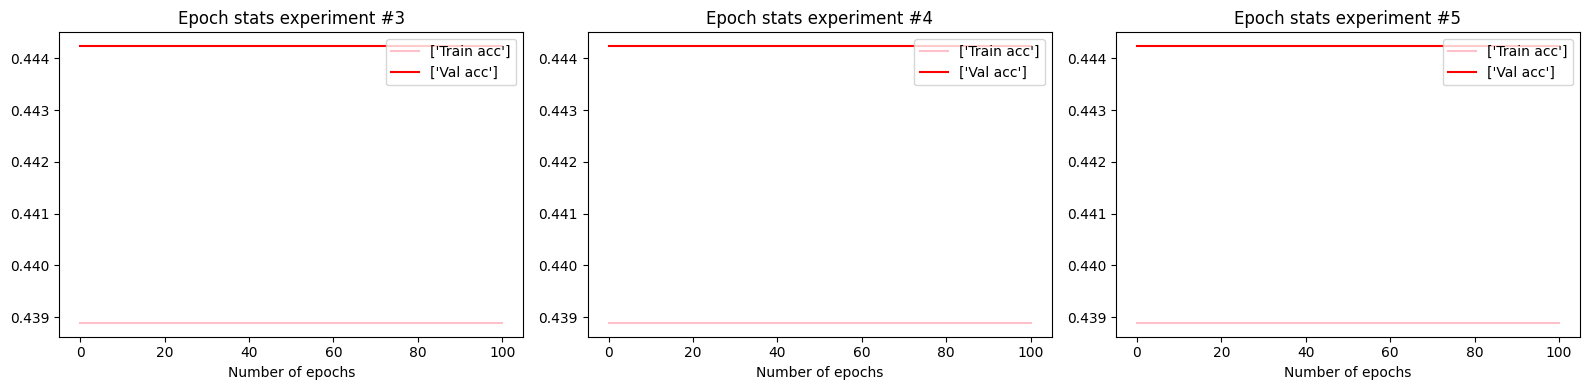

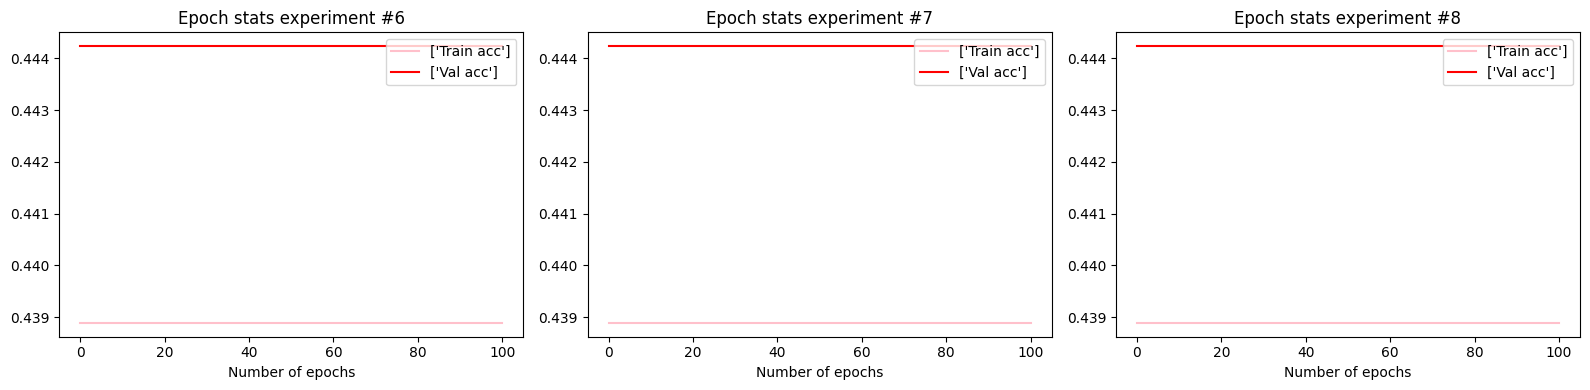

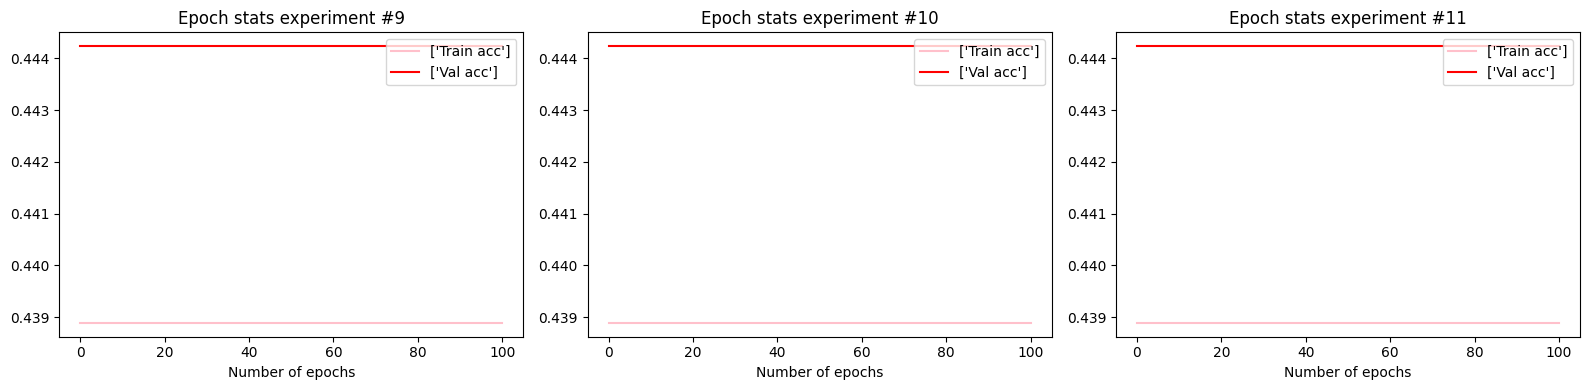

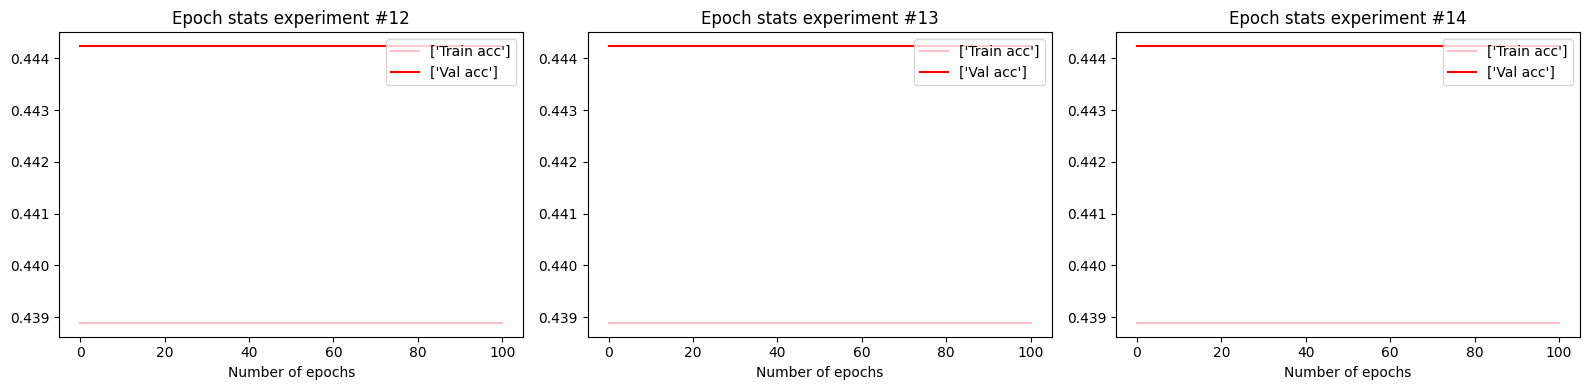

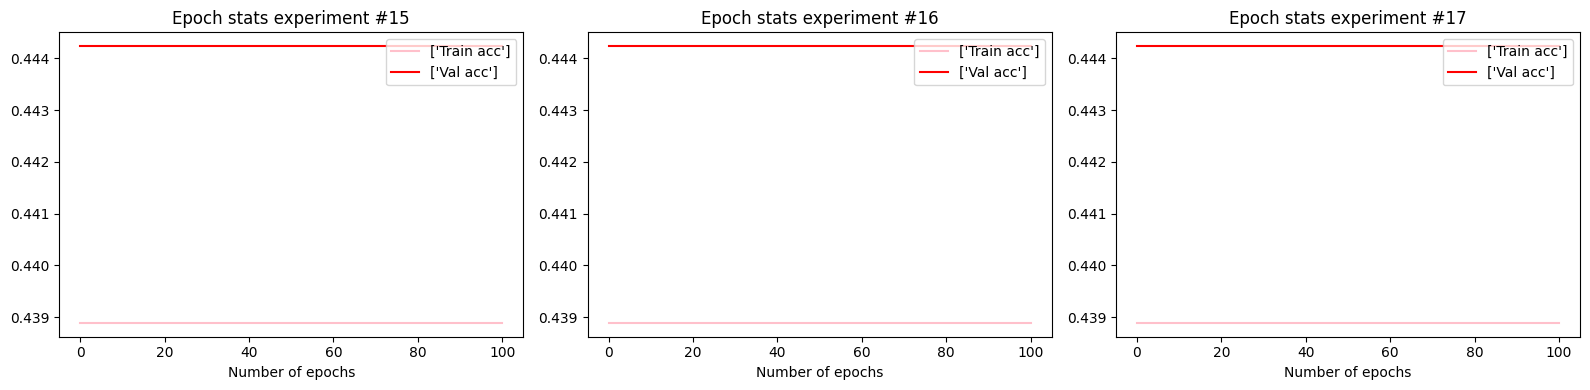

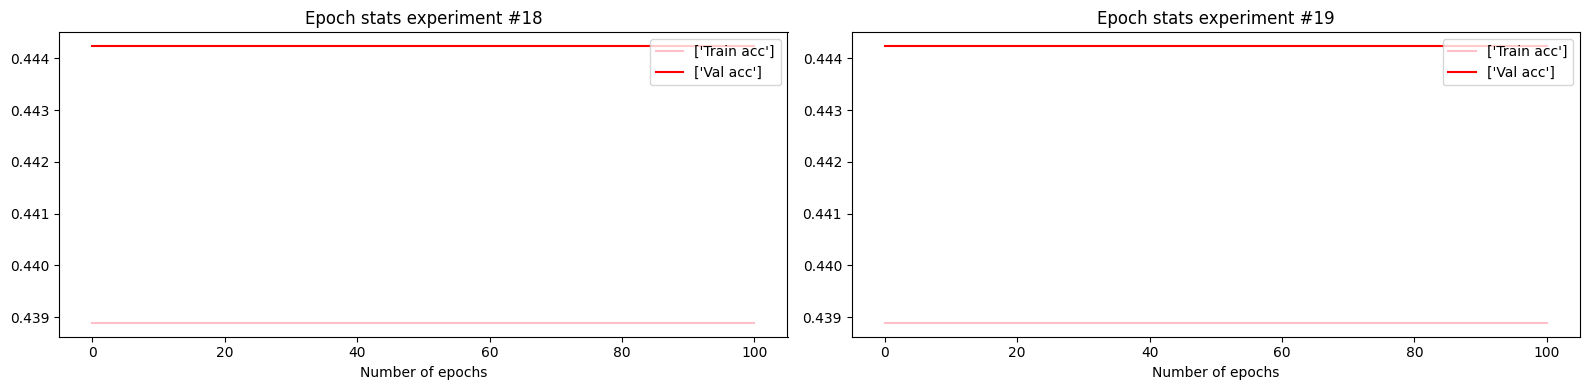

In [36]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

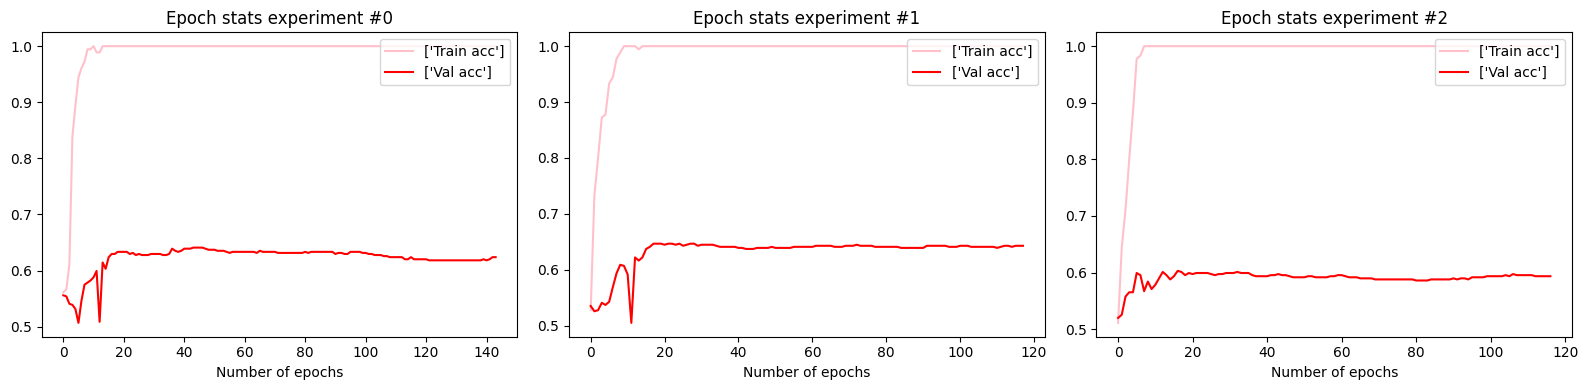

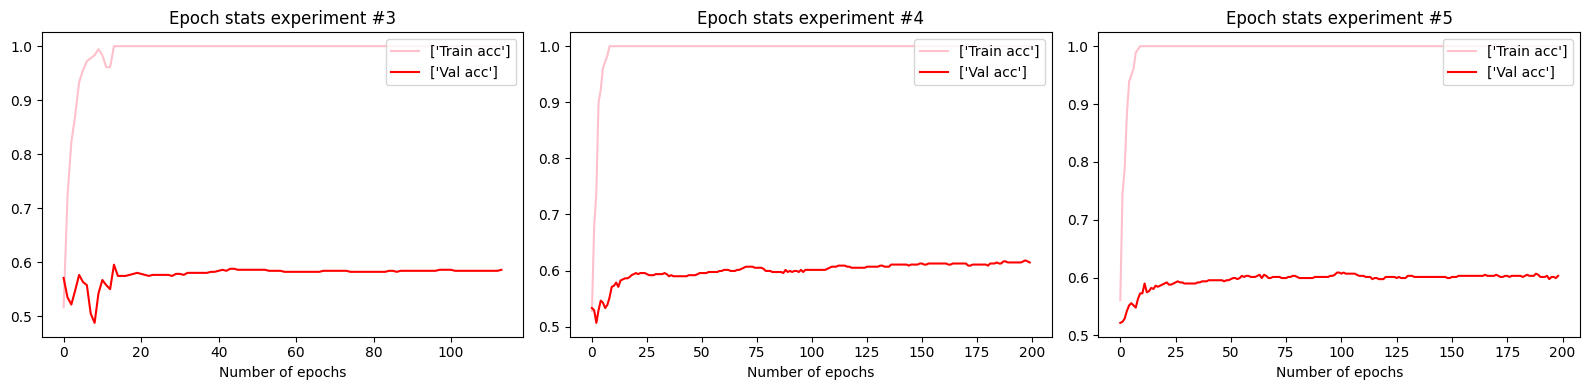

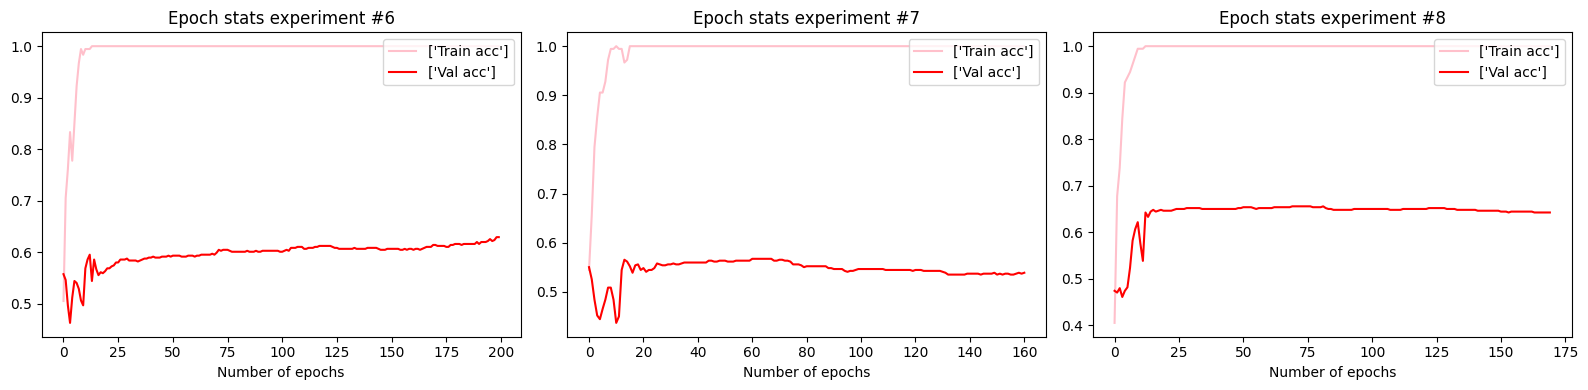

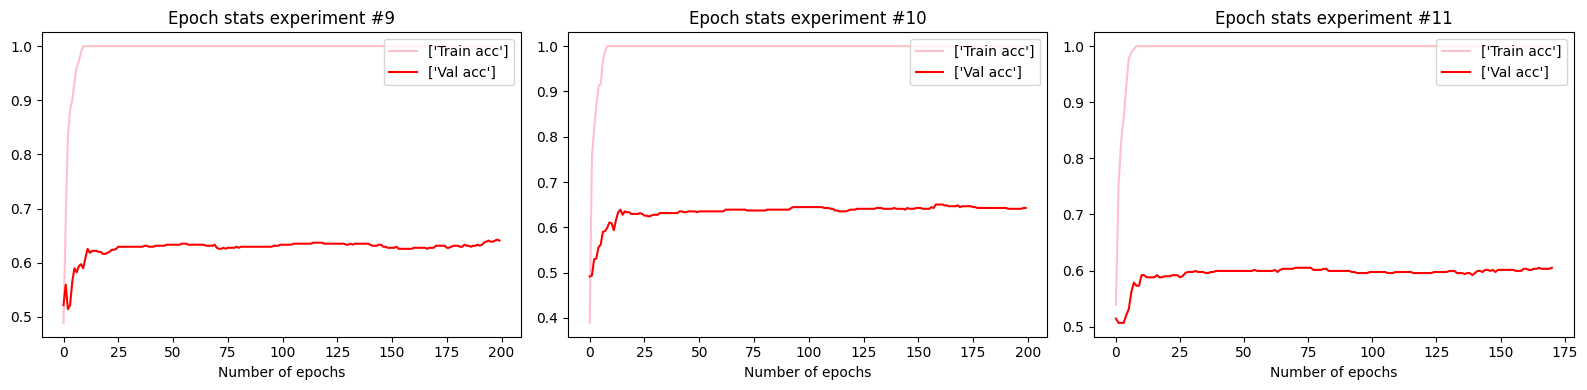

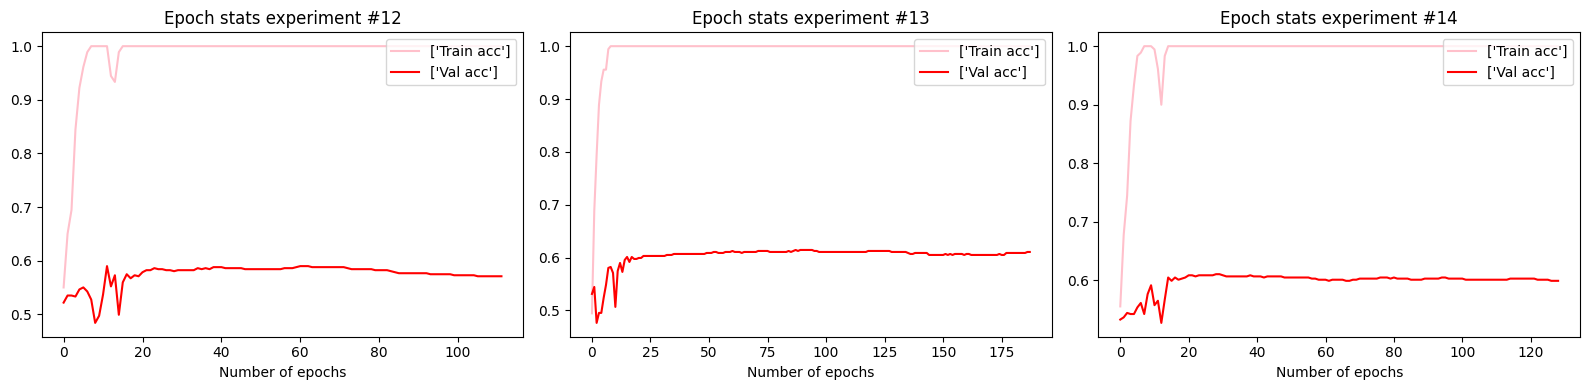

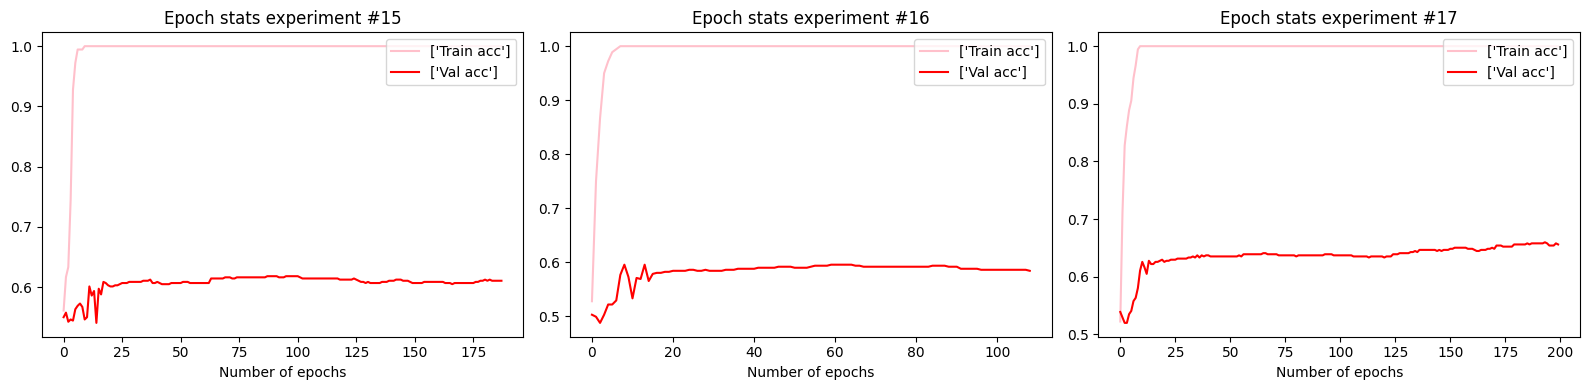

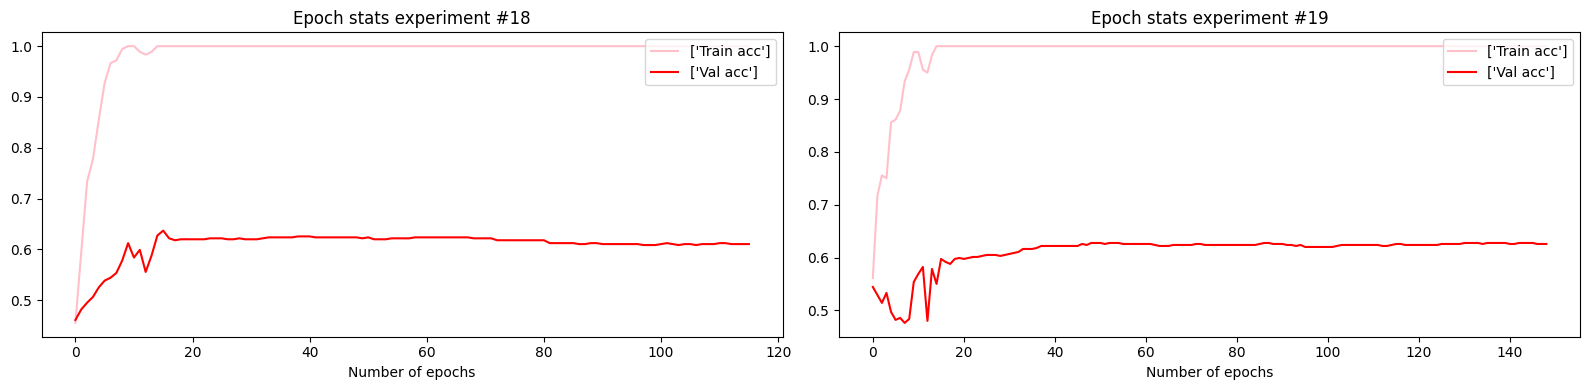

In [37]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [38]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_' + experiment_name))

RuntimeError: Error(s) in loading state_dict for CNN_Model:
	size mismatch for cnnf1_1.weight: copying a param with shape torch.Size([32, 1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1, 32]).
	size mismatch for cnnf1_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for cnnf2_1.weight: copying a param with shape torch.Size([32, 1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1, 32]).
	size mismatch for cnnf2_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for cnnf3_1.weight: copying a param with shape torch.Size([32, 1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1, 32]).
	size mismatch for cnnf3_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for cnnf1_2.weight: copying a param with shape torch.Size([32, 32, 2]) from checkpoint, the shape in current model is torch.Size([64, 64, 2]).
	size mismatch for cnnf1_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for cnnf2_2.weight: copying a param with shape torch.Size([32, 32, 2]) from checkpoint, the shape in current model is torch.Size([64, 64, 2]).
	size mismatch for cnnf2_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for cnnf3_2.weight: copying a param with shape torch.Size([32, 32, 2]) from checkpoint, the shape in current model is torch.Size([64, 64, 2]).
	size mismatch for cnnf3_2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for cnnf1_3.weight: copying a param with shape torch.Size([64, 32, 2]) from checkpoint, the shape in current model is torch.Size([128, 64, 2]).
	size mismatch for cnnf1_3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for cnnf2_3.weight: copying a param with shape torch.Size([64, 32, 2]) from checkpoint, the shape in current model is torch.Size([128, 64, 2]).
	size mismatch for cnnf2_3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for cnnf3_3.weight: copying a param with shape torch.Size([64, 32, 2]) from checkpoint, the shape in current model is torch.Size([128, 64, 2]).
	size mismatch for cnnf3_3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for cnnf1_4.weight: copying a param with shape torch.Size([64, 64, 2]) from checkpoint, the shape in current model is torch.Size([128, 128, 2]).
	size mismatch for cnnf1_4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for cnnf2_4.weight: copying a param with shape torch.Size([64, 64, 2]) from checkpoint, the shape in current model is torch.Size([128, 128, 2]).
	size mismatch for cnnf2_4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for cnnf3_4.weight: copying a param with shape torch.Size([64, 64, 2]) from checkpoint, the shape in current model is torch.Size([128, 128, 2]).
	size mismatch for cnnf3_4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for densef1.weight: copying a param with shape torch.Size([8, 64]) from checkpoint, the shape in current model is torch.Size([8, 128]).
	size mismatch for densef2.weight: copying a param with shape torch.Size([8, 64]) from checkpoint, the shape in current model is torch.Size([8, 128]).
	size mismatch for densef3.weight: copying a param with shape torch.Size([8, 64]) from checkpoint, the shape in current model is torch.Size([8, 128]).

## Top wrong predictions for best performing CNN model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

## Top wrong predictions for best performing LSTM model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

## Top wrong predictions for best performing DeepSets V1 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

## Top wrong predictions for best performing DeepSets V2 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

## Top wrong predictions for best performing Feedforward model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

# Saving Notebook State

In [ ]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

# Loading Notebook State

In [ ]:
import dill
experiment_name = "all_filters"
# dill.load_session('notebook_env_' + experiment_name + '.db')